In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import itertools

#sklearn modules
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score 

#keras modules
from keras.models import Sequential,load_model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

#graph visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab

import os
print(os.listdir('../input/fashionmnist'))

#configure graphs
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

['t10k-images-idx3-ubyte', 'train-labels-idx1-ubyte', 'fashion-mnist_train.csv', 'train-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'fashion-mnist_test.csv']


In [2]:
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')
df = train.copy()
df_test = test.copy()
print(df.head(),df.shape,df_test.shape)

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [3]:
print('list of classes:',df.label.unique()) #list all classes
print('null values in train:',df.isnull().any().sum())
print('null values in test:',df_test.isnull().any().sum())

# mapping classes in a dictionary
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

list of classes: [2 9 6 0 3 4 5 8 7 1]
null values in train: 0
null values in test: 0


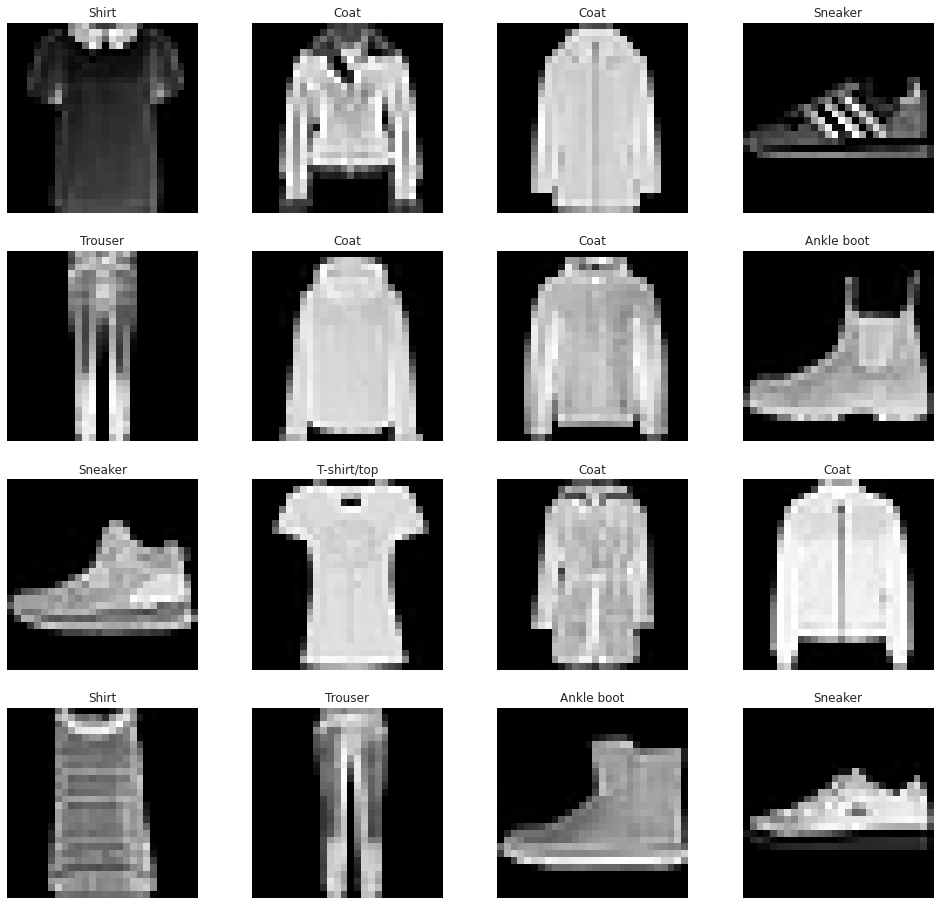

In [4]:
figure,axes = plt.subplots(4,4,figsize=(15,15))
for idx,row in enumerate(axes):
    for axe in row:
        index = np.random.randint(60000) #random images from train set
        img = df.drop('label',axis=1).values[index].reshape(28,28)
        cloths = df.loc[index,'label']
        axe.imshow(img,cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64


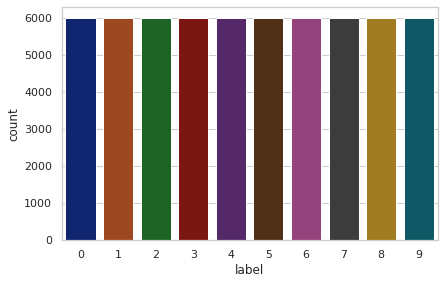

In [5]:
#visualizing number of examples for each class
print(df['label'].value_counts())
sns.countplot(x=df['label'],data = df)
np.random.seed(66)

In [6]:
# train-test-split
X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=66)
x_train = x_train.values.reshape((-1,28,28,1))
x_test = x_test.values.reshape((-1,28,28,1))

df_test.drop('label',axis=1,inplace=True)
df_test = df_test.values.reshape((-1,28,28,1))

In [7]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
df_test = df_test.astype('float32')/255

In [8]:
#one hot encoding
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

In [9]:
print(y_train.shape,y_test.shape)

(54000, 10) (6000, 10)


In [10]:
# CNN 
model = Sequential([layers.Conv2D(kernel_size=(3,3),filters=32,padding='same',activation='relu',
                                  strides=1,data_format='channels_last',input_shape=(28,28,1)),
                    layers.BatchNormalization(),
                    layers.Conv2D(kernel_size=(3,3),filters=32,padding='same',activation='relu',
                                  strides=1,data_format='channels_last'),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
                    layers.Conv2D(kernel_size=(3,3),filters=64,padding='same',activation='relu',
                                  strides=1,data_format='channels_last'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.25),
                    layers.Conv2D(kernel_size=(3,3),filters=128,padding='same',activation='relu',
                                  strides=1,data_format='channels_last'),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
                    layers.Flatten(),
                    layers.Dense(512,activation='relu'),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
                    layers.Dense(128,activation='relu'),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
                    layers.Dense(10,activation='softmax')
                   ])

In [11]:
opimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [12]:
model.compile(optimizer=opimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

In [14]:
#optimize learning rate for every epoch
reduce_lr = LearningRateScheduler(lambda x : 1e-3*0.9**x)

In [15]:
# data augmentation to tackle overfitting
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotates image 0 to 180 degrees
        zoom_range = 0.1,    # Randomly zooms image 
        shear_range = 0.3,   # shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,   # randomly shift images horizontally 
        height_shift_range=0.08,  # randomly shift images vertically 
        vertical_flip=True)       # randomly flip images vertically
datagen.fit(x_train)

In [16]:
#fit the model
batch_size = 128
epochs = 40
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,
                             validation_data=(x_test,y_test),
                             steps_per_epoch=x_train.shape[0]//batch_size,
                             verbose=2,
                             callbacks=[reduce_lr])

Epoch 1/40
421/421 - 23s - loss: 0.8222 - accuracy: 0.7052 - val_loss: 2.7695 - val_accuracy: 0.3295
Epoch 2/40
421/421 - 21s - loss: 0.5454 - accuracy: 0.8007 - val_loss: 0.4148 - val_accuracy: 0.8467
Epoch 3/40
421/421 - 21s - loss: 0.4650 - accuracy: 0.8306 - val_loss: 0.3468 - val_accuracy: 0.8712
Epoch 4/40
421/421 - 22s - loss: 0.4300 - accuracy: 0.8446 - val_loss: 0.3019 - val_accuracy: 0.8842
Epoch 5/40
421/421 - 21s - loss: 0.4006 - accuracy: 0.8551 - val_loss: 0.3010 - val_accuracy: 0.8898
Epoch 6/40
421/421 - 21s - loss: 0.3814 - accuracy: 0.8625 - val_loss: 0.2910 - val_accuracy: 0.8937
Epoch 7/40
421/421 - 22s - loss: 0.3642 - accuracy: 0.8704 - val_loss: 0.2678 - val_accuracy: 0.8990
Epoch 8/40
421/421 - 20s - loss: 0.3473 - accuracy: 0.8751 - val_loss: 0.2509 - val_accuracy: 0.9082
Epoch 9/40
421/421 - 20s - loss: 0.3383 - accuracy: 0.8789 - val_loss: 0.2577 - val_accuracy: 0.9035
Epoch 10/40
421/421 - 22s - loss: 0.3319 - accuracy: 0.8819 - val_loss: 0.2469 - val_accura

In [17]:
# evaluate model
score = model.evaluate(x_test,y_test)
print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

188/188 [==============================] - 1s 3ms/step - loss: 0.1851 - accuracy: 0.9320
Loss: 0.1851
Accuracy: 0.9320


lowest train loss:0.2416
lowest val loss:0.1851


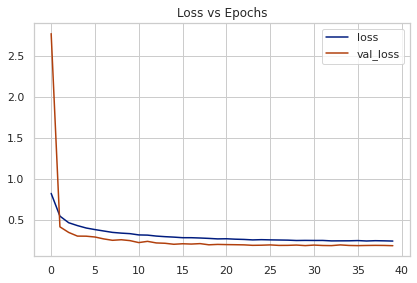

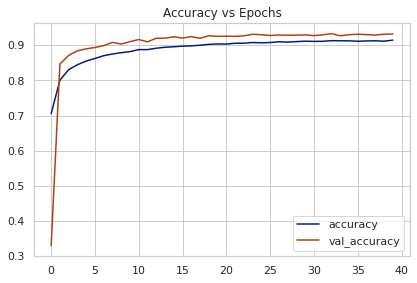

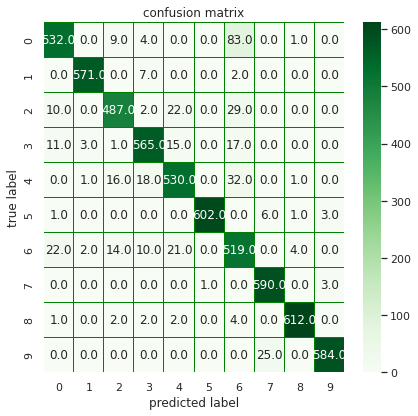

In [18]:
#plot graphs to visualize performance
historyDF = pd.DataFrame(history.history)
historyDF.loc[:,['loss','val_loss']].plot(title='Loss vs Epochs')
historyDF.loc[:,['accuracy','val_accuracy']].plot(title='Accuracy vs Epochs')
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_truth = np.argmax(y_test,axis=1)
confusion_mtx = confusion_matrix(y_truth,y_pred_classes)
figr,axs = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_mtx,annot=True,cmap='Greens',fmt='.1f',linewidths=0.01,linecolor='green',ax=axs)
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('true label')
print('lowest train loss:{:.4f}\nlowest val loss:{:.4f}'.format(min(historyDF[:]['loss']),min(historyDF[:]['val_loss'])))

In [19]:
# classification report to check precision,recall,F1 score and support
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(y_truth, y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.92      0.85      0.88       629
     Trouser       0.99      0.98      0.99       580
    Pullover       0.92      0.89      0.90       550
       Dress       0.93      0.92      0.93       612
        Coat       0.90      0.89      0.89       598
      Sandal       1.00      0.98      0.99       613
       Shirt       0.76      0.88      0.81       592
     Sneaker       0.95      0.99      0.97       594
         Bag       0.99      0.98      0.99       623
  Ankle Boot       0.99      0.96      0.97       609

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [20]:
# predictions on test data
X = df_test
Y = to_categorical(test.iloc[:,0])
score = model.evaluate(X,Y)
print('Loss : {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.1884 - accuracy: 0.9304
Loss : 0.1884
Accuracy: 0.9304


prediction is : Sneaker


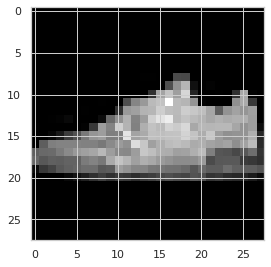

In [21]:
# invidual predictions
idx = 7211 #change to see prediction
img = X[idx].reshape(1,28,28,1)
plt.imshow(img.reshape(28,28),cmap='gray')
prediction = model.predict(img)
print('prediction is :', classes[np.argmax(prediction)])